## Importing libraries

Here we import the necessary libraries for the required program

In [ ]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn.metrics import roc_auc_score

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## Data Analysis and Data processing

In [2]:
train = pd.read_csv('Train/Train.csv')
train.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_1550,feature_1551,feature_1552,feature_1553,feature_1554,feature_1555,feature_1556,feature_1557,feature_1558,Class
0,100,160,1.6000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,20,83,4.1500,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,99,150,1.5151,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,40,40,1.0000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12,234,19.5000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's check the size of the dataframe

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1763 entries, 0 to 1762
Columns: 1559 entries, feature_1 to Class
dtypes: float64(1), int64(1558)
memory usage: 21.0 MB


As we can see from the set, we should try to minimize the dimensionality. 
So let us first drop the duplicate columns if any

In [4]:
duplicate = train.drop('Class',axis = 1).T.drop_duplicates().T.columns
Class = train['Class']
train = train[duplicate]
train['Class'] = Class

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1763 entries, 0 to 1762
Columns: 730 entries, feature_1 to Class
dtypes: float64(1), int64(729)
memory usage: 9.8 MB


The number of columns have reduced from 1559 to 730. i.e. more than half of the columns were duplicates

In [6]:
train.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_1549,feature_1550,feature_1551,feature_1552,feature_1553,feature_1554,feature_1555,feature_1557,feature_1558,Class
0,100,160,1.6000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,20,83,4.1500,1,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,99,150,1.5151,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,40,40,1.0000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12,234,19.5000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



From further inspection, we can see that feature_1, feature_2, feature_3 are numerical while the rest are binary.

So, let us count the number of values in each range in these 3 features and plot histogram based on that.

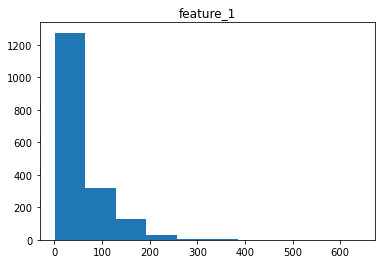

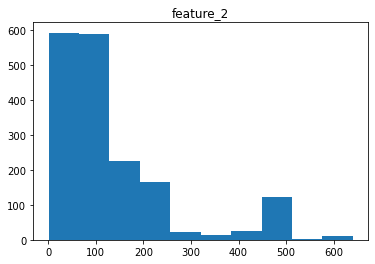

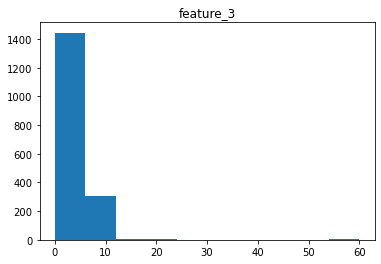

In [7]:
for i in train.columns[:3]:
    plt.hist(train[i])
    plt.title(i)
    plt.show()

Let us make a boxplot of these 3 features to understand them better. 

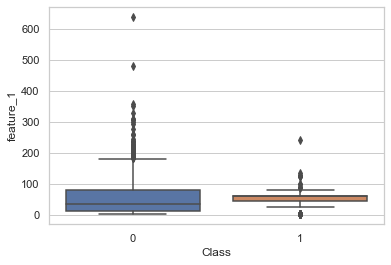

In [8]:
sns.set(style="whitegrid")
ax = sns.boxplot(x="Class", y="feature_1",data=train)

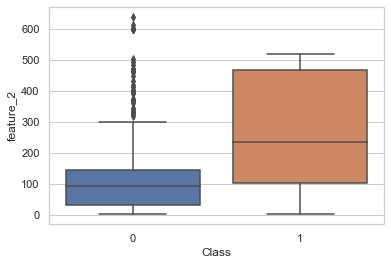

In [9]:
ax = sns.boxplot(x="Class", y="feature_2",data = train)

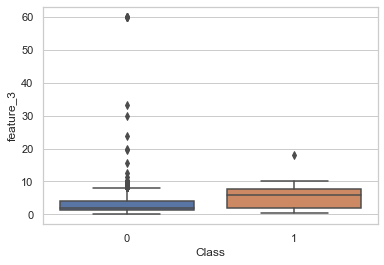

In [10]:
ax = sns.boxplot(x="Class", y="feature_3",data = train)

In [11]:
pd.DataFrame(train[['feature_1','feature_2','feature_3','Class']].corr()['Class'])

,Class
feature_1,0.006458
feature_2,0.330720
feature_3,0.108288
Class,1.000000


From above, we can see that these 3 features are really important for the model. 

Let us try to drop the columns that have more than 1761 zeroes (out of a possible 1763) since it won't make much of a difference in having those columns

In [12]:
zero = pd.DataFrame((train == 0).astype(int).sum(axis=0))
zero

,0
feature_1,0
feature_2,0
feature_3,0
feature_4,486
feature_5,1758
...,...
feature_1554,1756
feature_1555,1736
feature_1557,1746
feature_1558,1761


In [13]:
all_zero = zero[zero[0]>1761].index
train.drop(all_zero,axis=1,inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1763 entries, 0 to 1762
Columns: 723 entries, feature_1 to Class
dtypes: float64(1), int64(722)
memory usage: 9.7 MB


As seen from above, we were able to drop 7 more unnecessary features

Let us plot the values of the datas that we have.

(array([1620.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         143.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

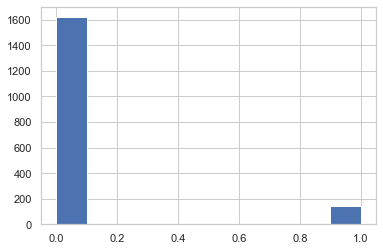

In [14]:
plt.hist(train["Class"])

In [15]:
train["Class"].value_counts()

0    1620
1     143
Name: Class, dtype: int64

As we can see, the number of anomalies(1) are way less compared to the normal(0). 

Hence, we need to implement data resampling process. In this process, we try to create new values in the anomalies while try to delete some values from the normal ones.

## Data resampling

In [16]:
Sm = SMOTE()
X = train.drop("Class", axis = 1)
y = train["Class"]

In [17]:
#Splitting the set into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, stratify = y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1586, 722), (177, 722), (1586,), (177,))

Let us do resampling of training set data

In [18]:
x_train, y_train = Sm.fit_resample(X_train, y_train)
x_train.shape, y_train.shape, y_train.value_counts()

((2914, 722),
 (2914,),
 1    1457
 0    1457
 Name: Class, dtype: int64)

In [19]:
x_train_re, x_test_re, y_train_re, y_test_re = train_test_split(x_train, y_train, test_size = 0.1, stratify = y_train)

In [20]:
y_train_re.value_counts()

1    1311
0    1311
Name: Class, dtype: int64

## PCA for dimensionality reduction

We can see that, even after dropping features, we still have 723 features which is a lot.

We will try to reduce the features to 3 components using Principal Component Analysis (PCA)

In [21]:
pca = PCA(n_components = 3)

In [22]:
pca_result = pca.fit_transform(X)

In [23]:
print(pca.explained_variance_ratio_)

[8.66966999e-01 1.32106927e-01 5.72958639e-04]


In [24]:
train_copy = train.copy()
train_copy['pca-one'] = pca_result[:,0]
train_copy['pca-two'] = pca_result[:,1] 
train_copy['pca-three'] = pca_result[:,2]

Let us try to plot the first two components on a 2D plane

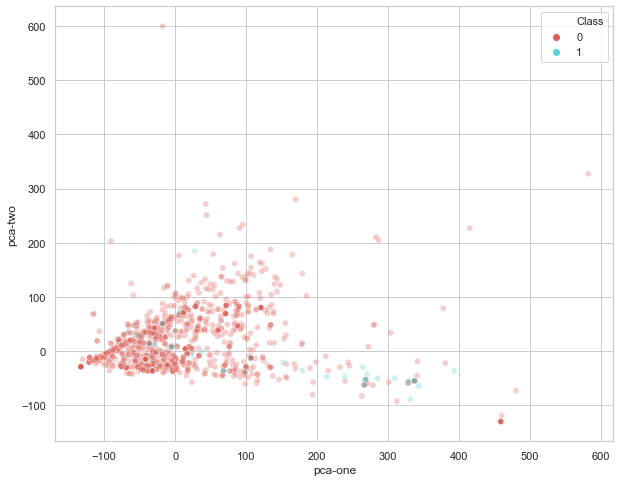

In [25]:
rndperm = np.random.permutation(train_copy.shape[0])
plt.figure(figsize=(10,8))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="Class",
    palette=sns.color_palette("hls", 2),
    data= train_copy.loc[rndperm,:],
    legend="full",
    alpha=0.3
)

Let us trry to plot them on a 3 dimensional axis

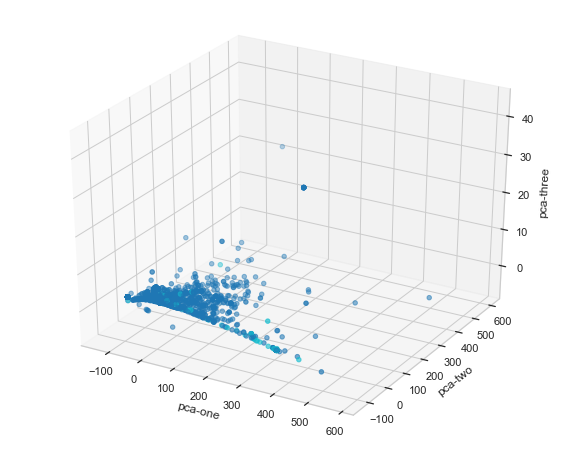

In [27]:
ax = plt.figure(figsize=(10,8)).gca(projection='3d')
ax.scatter(
    xs=train_copy.loc[rndperm,:]["pca-one"], 
    ys=train_copy.loc[rndperm,:]["pca-two"], 
    zs=train_copy.loc[rndperm,:]["pca-three"], 
    c=train_copy.loc[rndperm,:]["Class"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

## Model building

Hyperparameter tuning is very important here.

scale_pos_weight : To counter the imbalanced nature of the dataset

colsample_bytree, subsample, reg_lambda : To counter overfitting

In [28]:
from xgboost import XGBClassifier

In [29]:
model = XGBClassifier(silent=True,
                      booster = 'gbtree',
                      scale_pos_weight=5,
                      learning_rate=0.01,  
                      colsample_bytree = 0.7,
                      subsample = 0.5,
                      max_delta_step = 3,
                      reg_lambda = 2,
                      objective='binary:logistic',
                      n_estimators=818, 
                      max_depth=8,
                     )

In [31]:
eval_set = [(x_test_re, y_test_re)]
eval_metric = ["logloss"]

In [32]:
%time model.fit(x_test_re, y_test_re, early_stopping_rounds=50, eval_metric=eval_metric, eval_set=eval_set)

C:\Users\FAIZ NAZEER\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:00:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-logloss:0.69148
[1]	validation_0-logloss:0.68785
[2]	validation_0-logloss:0.68515
[3]	validation_0-logloss:0.68169
[4]	validation_0-logloss:0.67827
[5]	validation_0-logloss:0.67496
[6]	validation_0-logloss:0.67165
[7]	validation_0-logloss:0.66788
[8]	validation_0-logloss:0.66484
[9]	validation_0-logloss:0.66138
[10]	validation_0-logloss:0.65853
[11]	validation_0-logloss:0.65663
[12]	validation_0-logloss:0.65340
[13]	validation_0-logloss:0.65067
[14]	validation_0-logloss:0.64755
[15]	validation_0-logloss:0.64607
[16]	validation_0-logloss:0.64312
[17]	validation_0-logloss:0.64127
[18]	validatio

[227]	validation_0-logloss:0.41832
[228]	validation_0-logloss:0.41807
[229]	validation_0-logloss:0.41756
[230]	validation_0-logloss:0.41744
[231]	validation_0-logloss:0.41726
[232]	validation_0-logloss:0.41673
[233]	validation_0-logloss:0.41670
[234]	validation_0-logloss:0.41596
[235]	validation_0-logloss:0.41541
[236]	validation_0-logloss:0.41500
[237]	validation_0-logloss:0.41432
[238]	validation_0-logloss:0.41414
[239]	validation_0-logloss:0.41347
[240]	validation_0-logloss:0.41296
[241]	validation_0-logloss:0.41260
[242]	validation_0-logloss:0.41215
[243]	validation_0-logloss:0.41189
[244]	validation_0-logloss:0.41133
[245]	validation_0-logloss:0.41116
[246]	validation_0-logloss:0.41105
[247]	validation_0-logloss:0.41042
[248]	validation_0-logloss:0.41026
[249]	validation_0-logloss:0.40966
[250]	validation_0-logloss:0.40932
[251]	validation_0-logloss:0.40955
[252]	validation_0-logloss:0.40966
[253]	validation_0-logloss:0.40983
[254]	validation_0-logloss:0.40914
[255]	validation_0-l

[462]	validation_0-logloss:0.34897
[463]	validation_0-logloss:0.34846
[464]	validation_0-logloss:0.34803
[465]	validation_0-logloss:0.34739
[466]	validation_0-logloss:0.34700
[467]	validation_0-logloss:0.34685
[468]	validation_0-logloss:0.34657
[469]	validation_0-logloss:0.34597
[470]	validation_0-logloss:0.34563
[471]	validation_0-logloss:0.34556
[472]	validation_0-logloss:0.34516
[473]	validation_0-logloss:0.34507
[474]	validation_0-logloss:0.34498
[475]	validation_0-logloss:0.34447
[476]	validation_0-logloss:0.34439
[477]	validation_0-logloss:0.34410
[478]	validation_0-logloss:0.34393
[479]	validation_0-logloss:0.34367
[480]	validation_0-logloss:0.34332
[481]	validation_0-logloss:0.34320
[482]	validation_0-logloss:0.34280
[483]	validation_0-logloss:0.34254
[484]	validation_0-logloss:0.34239
[485]	validation_0-logloss:0.34209
[486]	validation_0-logloss:0.34121
[487]	validation_0-logloss:0.34071
[488]	validation_0-logloss:0.34082
[489]	validation_0-logloss:0.34056
[490]	validation_0-l

[697]	validation_0-logloss:0.30440
[698]	validation_0-logloss:0.30467
[699]	validation_0-logloss:0.30429
[700]	validation_0-logloss:0.30431
[701]	validation_0-logloss:0.30418
[702]	validation_0-logloss:0.30403
[703]	validation_0-logloss:0.30374
[704]	validation_0-logloss:0.30368
[705]	validation_0-logloss:0.30337
[706]	validation_0-logloss:0.30335
[707]	validation_0-logloss:0.30307
[708]	validation_0-logloss:0.30292
[709]	validation_0-logloss:0.30266
[710]	validation_0-logloss:0.30291
[711]	validation_0-logloss:0.30258
[712]	validation_0-logloss:0.30249
[713]	validation_0-logloss:0.30203
[714]	validation_0-logloss:0.30180
[715]	validation_0-logloss:0.30155
[716]	validation_0-logloss:0.30124
[717]	validation_0-logloss:0.30090
[718]	validation_0-logloss:0.30081
[719]	validation_0-logloss:0.30047
[720]	validation_0-logloss:0.30036
[721]	validation_0-logloss:0.30018
[722]	validation_0-logloss:0.29975
[723]	validation_0-logloss:0.29956
[724]	validation_0-logloss:0.29951
[725]	validation_0-l

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=3, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=818, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=2, scale_pos_weight=5, silent=True,
              subsample=0.5, tree_method='exact', validate_parameters=1,
              verbosity=None)

## Model evaluation

Checking accuracy of the model

In [34]:
predictions = model.predict_proba(x_test_re)[:,-1]

In [35]:
roc_auc_score(y_test_re, predictions)

0.9793582285607056

So, we are getting an accuracy of 97.9% in classifying the anomalies and normal ones correctly.